In [92]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt

env_path = '../data/.env'
load_dotenv(dotenv_path=env_path)

HOPSWORKS_API_KEY = os.getenv("HOPSWORKS_API_KEY")

In [96]:
today = datetime.datetime.now(datetime.timezone.utc) - datetime.timedelta(0)
today

datetime.datetime(2024, 12, 30, 18, 36, 31, 519134, tzinfo=datetime.timezone.utc)

In [4]:
project = hopsworks.login(project='AMomozZz', api_key_value=HOPSWORKS_API_KEY)

2024-12-30 18:50:43,696 INFO: Closing external client and cleaning up certificates.
2024-12-30 18:50:43,698 INFO: Initializing external client
2024-12-30 18:50:43,698 INFO: Base URL: https://c.app.hopsworks.ai:443
2024-12-30 18:51:03,617 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1163416


In [5]:
fs = project.get_feature_store() 
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="gold_prices_xgboost_model",
    version=1,
)
exchange_fg = fs.get_feature_group(
    name='exchange_feature_group',
    version=1,
)
gold_fg = fs.get_feature_group(
    name='gold_feature_group',
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

## Get gold price prediction model

In [6]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='1.1563235E3', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float', 'float', 'floa...
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Prepare inference data

In [7]:
batch_data = exchange_fg.filter(exchange_fg.date >= today).read().sort_values(by=['date'], ascending=True, ignore_index=True)
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.65s) 


,date,aud,bgn,cad,chf,czk,dkk,eur,gbp,hkd,...,close_price_1,close_price_2,close_price_3,close_price_4,close_price_5,close_price_6,close_price_7,close_price_8,close_price_9,close_price_10
0,2024-12-31 00:00:00+00:00,1.537346,1.851404,1.426810,0.867157,24.537416,7.081013,0.952036,0.792289,7.775136,...,0.0,2636.5,2638.800049,0.000000,2620.000000,2612.300049,2628.699951,2592.199951,2636.500000,2644.399902
1,2025-01-01 00:00:00+00:00,1.550713,1.845641,1.381803,0.879927,23.194738,6.919368,0.938662,0.788186,7.767988,...,0.0,0.0,2636.500000,2638.800049,0.000000,2620.000000,2612.300049,2628.699951,2592.199951,2636.500000
2,2025-01-02 00:00:00+00:00,1.608766,1.874190,1.411317,0.876733,24.185942,7.124239,0.946272,0.787828,7.776083,...,0.0,0.0,0.000000,2636.500000,2638.800049,0.000000,2620.000000,2612.300049,2628.699951,2592.199951
3,2025-01-03 00:00:00+00:00,1.560774,1.871500,1.362973,0.883546,24.057713,6.962848,0.939616,0.792183,7.770098,...,0.0,0.0,0.000000,0.000000,2636.500000,2638.800049,0.000000,2620.000000,2612.300049,2628.699951


## Time Series Forecasting

In [8]:
# batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
#     batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant', "pm25_yesterday"]])

l = []
for i in exchange_fg.features:
    if i.name != 'date':
        l.append(i.name)

batch_data['predicted_close_price'] = None

for i in range(0, len(batch_data)):
    p = retrieved_xgboost_model.predict(batch_data.iloc[[i]][l])[0]
    batch_data.at[i, 'predicted_close_price'] = p
    index = 1
    for j in range(i+1, batch_data.shape[0]):
        batch_data.at[j, f"close_price_{index}"] = p
        index += 1

display(batch_data)
batch_data.info()

,date,aud,bgn,cad,chf,czk,dkk,eur,gbp,hkd,...,close_price_2,close_price_3,close_price_4,close_price_5,close_price_6,close_price_7,close_price_8,close_price_9,close_price_10,predicted_close_price
0,2024-12-31 00:00:00+00:00,1.537346,1.851404,1.426810,0.867157,24.537416,7.081013,0.952036,0.792289,7.775136,...,2636.500000,2638.800049,0.000000,2620.000000,2612.300049,2628.699951,2592.199951,2636.500000,2644.399902,2482.188965
1,2025-01-01 00:00:00+00:00,1.550713,1.845641,1.381803,0.879927,23.194738,6.919368,0.938662,0.788186,7.767988,...,0.000000,2636.500000,2638.800049,0.000000,2620.000000,2612.300049,2628.699951,2592.199951,2636.500000,2393.211426
2,2025-01-02 00:00:00+00:00,1.608766,1.874190,1.411317,0.876733,24.185942,7.124239,0.946272,0.787828,7.776083,...,2482.188965,0.000000,2636.500000,2638.800049,0.000000,2620.000000,2612.300049,2628.699951,2592.199951,2364.537354
3,2025-01-03 00:00:00+00:00,1.560774,1.871500,1.362973,0.883546,24.057713,6.962848,0.939616,0.792183,7.770098,...,2393.211426,2482.188965,0.000000,2636.500000,2638.800049,0.000000,2620.000000,2612.300049,2628.699951,2368.986572


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype                  
---  ------                 --------------  -----                  
 0   date                   4 non-null      datetime64[us, Etc/UTC]
 1   aud                    4 non-null      float64                
 2   bgn                    4 non-null      float64                
 3   cad                    4 non-null      float64                
 4   chf                    4 non-null      float64                
 5   czk                    4 non-null      float64                
 6   dkk                    4 non-null      float64                
 7   eur                    4 non-null      float64                
 8   gbp                    4 non-null      float64                
 9   hkd                    4 non-null      float64                
 10  huf                    4 non-null      float64                
 11  jpy       

## Inference metrics

In [53]:
# Fill in the number of days before the date on which you made the forecast (base_date)
# batch_data = batch_data.sort_values(by=['date'])
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
display(batch_data)
batch_data.info()

,date,aud,bgn,cad,chf,czk,dkk,eur,gbp,hkd,...,close_price_3,close_price_4,close_price_5,close_price_6,close_price_7,close_price_8,close_price_9,close_price_10,predicted_close_price,days_before_forecast_day
0,2024-12-30 00:00:00+00:00,1.541141,1.838320,1.379623,0.897305,24.417318,6.989988,0.950156,0.789757,7.770858,...,0.000000,2620.000000,2612.300049,2628.699951,2592.199951,2636.500000,2644.399902,2651.399902,2576.816895,1
1,2024-12-31 00:00:00+00:00,1.537346,1.851404,1.426810,0.867157,24.537416,7.081013,0.952036,0.792289,7.775136,...,2638.800049,0.000000,2620.000000,2612.300049,2628.699951,2592.199951,2636.500000,2644.399902,2592.281738,2
2,2025-01-01 00:00:00+00:00,1.550713,1.845641,1.381803,0.879927,23.194738,6.919368,0.938662,0.788186,7.767988,...,2636.500000,2638.800049,0.000000,2620.000000,2612.300049,2628.699951,2592.199951,2636.500000,2623.751709,3
3,2025-01-02 00:00:00+00:00,1.608766,1.874190,1.411317,0.876733,24.185942,7.124239,0.946272,0.787828,7.776083,...,2576.816895,2636.500000,2638.800049,0.000000,2620.000000,2612.300049,2628.699951,2592.199951,2582.35498,4
4,2025-01-03 00:00:00+00:00,1.560774,1.871500,1.362973,0.883546,24.057713,6.962848,0.939616,0.792183,7.770098,...,2592.281738,2576.816895,2636.500000,2638.800049,0.000000,2620.000000,2612.300049,2628.699951,2610.850098,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype                  
---  ------                    --------------  -----                  
 0   date                      5 non-null      datetime64[us, Etc/UTC]
 1   aud                       5 non-null      float64                
 2   bgn                       5 non-null      float64                
 3   cad                       5 non-null      float64                
 4   chf                       5 non-null      float64                
 5   czk                       5 non-null      float64                
 6   dkk                       5 non-null      float64                
 7   eur                       5 non-null      float64                
 8   gbp                       5 non-null      float64                
 9   hkd                       5 non-null      float64                
 10  huf                       5 non-null      

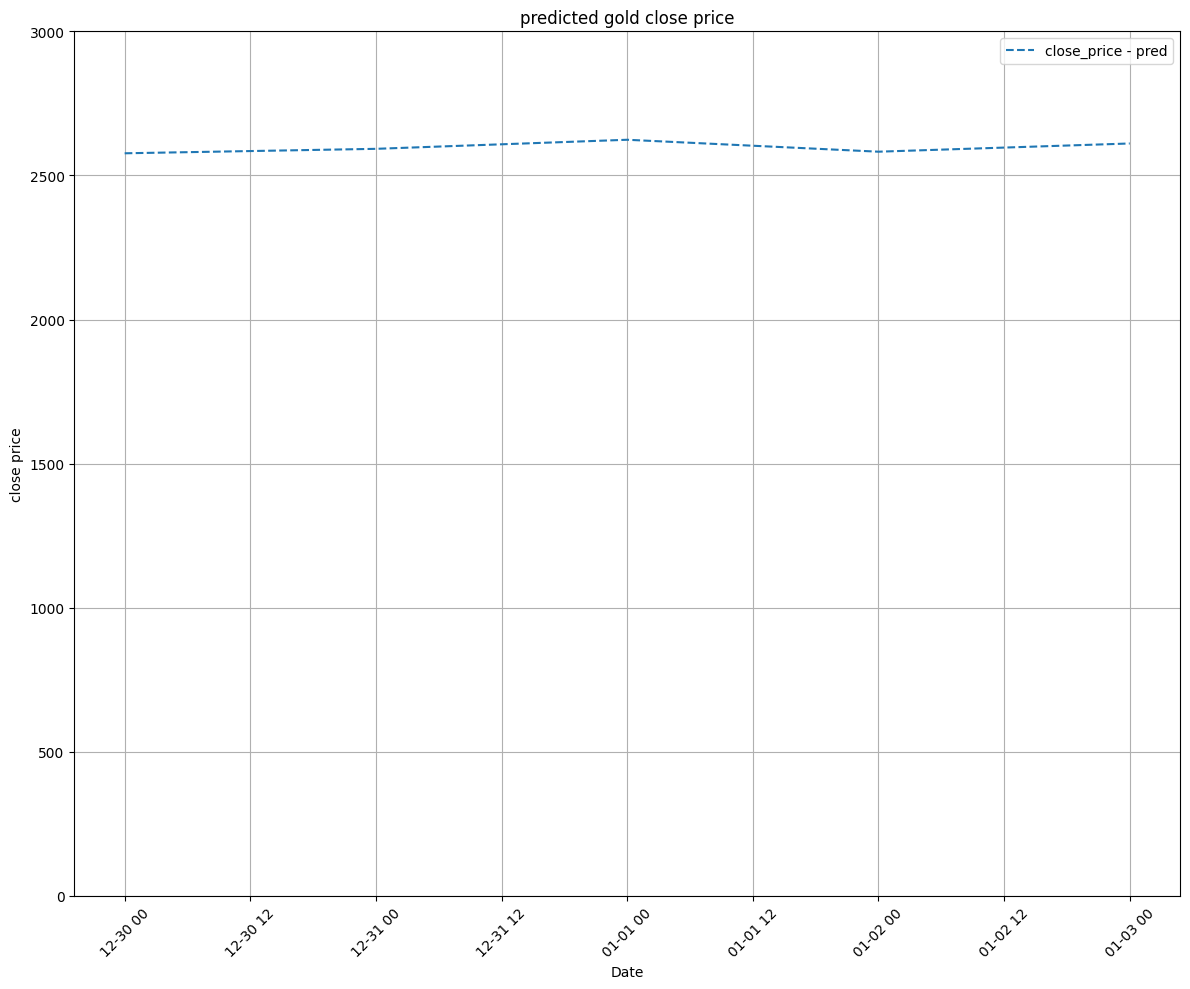

In [91]:
file_path = "../docs/goldPrice/assets/img/gold_price_forecast.png"
plt.figure(figsize=(12, 10))
plt.plot(batch_data["date"], batch_data["predicted_close_price"], label=f"close_price - pred", color='red', linewidth=2, marker='o', markersize=5, markerfacecolor='blue')
plt.title(f"predicted gold close price")
plt.xlabel("Date")
plt.ylabel("close price")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.ylim(0, 3000)
plt.tight_layout()
plt.savefig(file_path)
plt.show()
plt.show()

## Merge to feature store

In [10]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='gold_predictions',
    description='gold prices prediction monitoring',
    version=1,
    primary_key=['date'],
    event_time="date"
)

In [56]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1163416/fs/1154119/fg/1394350


Uploading Dataframe: 100.00% |██████████| Rows 5/5 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: gold_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1163416/jobs/named/gold_predictions_1_offline_fg_materialization/executions
2024-12-30 01:38:48,455 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2024-12-30 01:38:51,607 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2024-12-30 01:40:32,676 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2024-12-30 01:40:32,835 INFO: Waiting for log aggregation to finish.
2024-12-30 01:40:41,381 INFO: Execution finished successfully.


(Job('gold_predictions_1_offline_fg_materialization', 'SPARK'), None)

In [11]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (3.18s) 


In [12]:
display(monitor_fg.read().sort_values(by=['date'], ascending=True))
display(monitoring_df)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.63s) 


,date,aud,bgn,cad,chf,czk,dkk,eur,gbp,hkd,...,close_price_3,close_price_4,close_price_5,close_price_6,close_price_7,close_price_8,close_price_9,close_price_10,predicted_close_price,days_before_forecast_day
6,2024-12-19 00:00:00+00:00,1.599900,1.881500,1.436300,0.896490,24.172000,7.177800,0.962000,0.793120,7.771500,...,2651.399902,2656.000000,2687.500000,2733.800049,2697.600098,2664.899902,2638.600098,2626.600098,2621.218750,1
8,2024-12-20 00:00:00+00:00,1.604800,1.882400,1.438500,0.894800,24.178000,7.181300,0.962460,0.798510,7.772400,...,2644.399902,2651.399902,2656.000000,2687.500000,2733.800049,2697.600098,2664.899902,2638.600098,2619.088623,1
5,2024-12-23 00:00:00+00:00,1.603700,1.881800,1.441200,0.898300,24.213000,7.176900,0.962190,0.798570,7.770300,...,2636.500000,2644.399902,2651.399902,2656.000000,2687.500000,2733.800049,2697.600098,2664.899902,2613.676270,1
9,2024-12-24 00:00:00+00:00,1.604700,1.881500,1.441800,0.900240,24.180000,7.177300,0.962000,0.796580,7.767500,...,2592.199951,2636.500000,2644.399902,2651.399902,2656.000000,2687.500000,2733.800049,2697.600098,2622.749268,1
7,2024-12-27 00:00:00+00:00,1.607800,1.874300,1.437700,0.900430,24.150000,7.149200,0.958310,0.796340,7.761400,...,2620.000000,2612.300049,2628.699951,2592.199951,2636.500000,2644.399902,2651.399902,2656.000000,2543.347900,1
3,2024-12-30 00:00:00+00:00,1.541141,1.838320,1.379623,0.897305,24.417318,6.989988,0.950156,0.789757,7.770858,...,0.000000,2620.000000,2612.300049,2628.699951,2592.199951,2636.500000,2644.399902,2651.399902,2576.816895,1
0,2024-12-31 00:00:00+00:00,1.537346,1.851404,1.426810,0.867157,24.537416,7.081013,0.952036,0.792289,7.775136,...,2638.800049,0.000000,2620.000000,2612.300049,2628.699951,2592.199951,2636.500000,2644.399902,2592.281738,2
1,2025-01-01 00:00:00+00:00,1.550713,1.845641,1.381803,0.879927,23.194738,6.919368,0.938662,0.788186,7.767988,...,2636.500000,2638.800049,0.000000,2620.000000,2612.300049,2628.699951,2592.199951,2636.500000,2623.751709,3
2,2025-01-02 00:00:00+00:00,1.608766,1.874190,1.411317,0.876733,24.185942,7.124239,0.946272,0.787828,7.776083,...,2576.816895,2636.500000,2638.800049,0.000000,2620.000000,2612.300049,2628.699951,2592.199951,2582.354980,4
4,2025-01-03 00:00:00+00:00,1.560774,1.871500,1.362973,0.883546,24.057713,6.962848,0.939616,0.792183,7.770098,...,2592.281738,2576.816895,2636.500000,2638.800049,0.000000,2620.000000,2612.300049,2628.699951,2610.850098,5


,date,aud,bgn,cad,chf,czk,dkk,eur,gbp,hkd,...,close_price_3,close_price_4,close_price_5,close_price_6,close_price_7,close_price_8,close_price_9,close_price_10,predicted_close_price,days_before_forecast_day
0,2024-12-30 00:00:00+00:00,1.541141,1.83832,1.379623,0.897305,24.417318,6.989988,0.950156,0.789757,7.770858,...,0.000000,2620.000000,2612.300049,2628.699951,2592.199951,2636.500000,2644.399902,2651.399902,2576.816895,1
1,2024-12-23 00:00:00+00:00,1.603700,1.88180,1.441200,0.898300,24.213000,7.176900,0.962190,0.798570,7.770300,...,2636.500000,2644.399902,2651.399902,2656.000000,2687.500000,2733.800049,2697.600098,2664.899902,2613.676270,1
2,2024-12-19 00:00:00+00:00,1.599900,1.88150,1.436300,0.896490,24.172000,7.177800,0.962000,0.793120,7.771500,...,2651.399902,2656.000000,2687.500000,2733.800049,2697.600098,2664.899902,2638.600098,2626.600098,2621.218750,1
3,2024-12-27 00:00:00+00:00,1.607800,1.87430,1.437700,0.900430,24.150000,7.149200,0.958310,0.796340,7.761400,...,2620.000000,2612.300049,2628.699951,2592.199951,2636.500000,2644.399902,2651.399902,2656.000000,2543.347900,1
4,2024-12-20 00:00:00+00:00,1.604800,1.88240,1.438500,0.894800,24.178000,7.181300,0.962460,0.798510,7.772400,...,2644.399902,2651.399902,2656.000000,2687.500000,2733.800049,2697.600098,2664.899902,2638.600098,2619.088623,1
5,2024-12-24 00:00:00+00:00,1.604700,1.88150,1.441800,0.900240,24.180000,7.177300,0.962000,0.796580,7.767500,...,2592.199951,2636.500000,2644.399902,2651.399902,2656.000000,2687.500000,2733.800049,2697.600098,2622.749268,1


In [14]:
gold_df = gold_fg.read()
gold_fg.read().sort_values(by=['date'], ascending=True).tail(5)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.14s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.77s) 


,date,close_price
5611,2024-12-20 00:00:00+00:00,2628.699951
1922,2024-12-23 00:00:00+00:00,2612.300049
1809,2024-12-24 00:00:00+00:00,2620.000000
6102,2024-12-26 00:00:00+00:00,2638.800049
6103,2024-12-27 00:00:00+00:00,2636.500000


## Backfill for first time prediction

In [15]:
outcome_df = gold_df[['date', 'close_price']]
preds_df = monitoring_df[['date', 'predicted_close_price']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(exchange_fg, gold_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

,date,predicted_close_price,close_price
1,2024-12-19 00:00:00+00:00,2621.218750,2592.199951
3,2024-12-20 00:00:00+00:00,2619.088623,2628.699951
0,2024-12-23 00:00:00+00:00,2613.676270,2612.300049
4,2024-12-24 00:00:00+00:00,2622.749268,2620.000000
2,2024-12-27 00:00:00+00:00,2543.347900,2636.500000


## Inference Vs Actual data

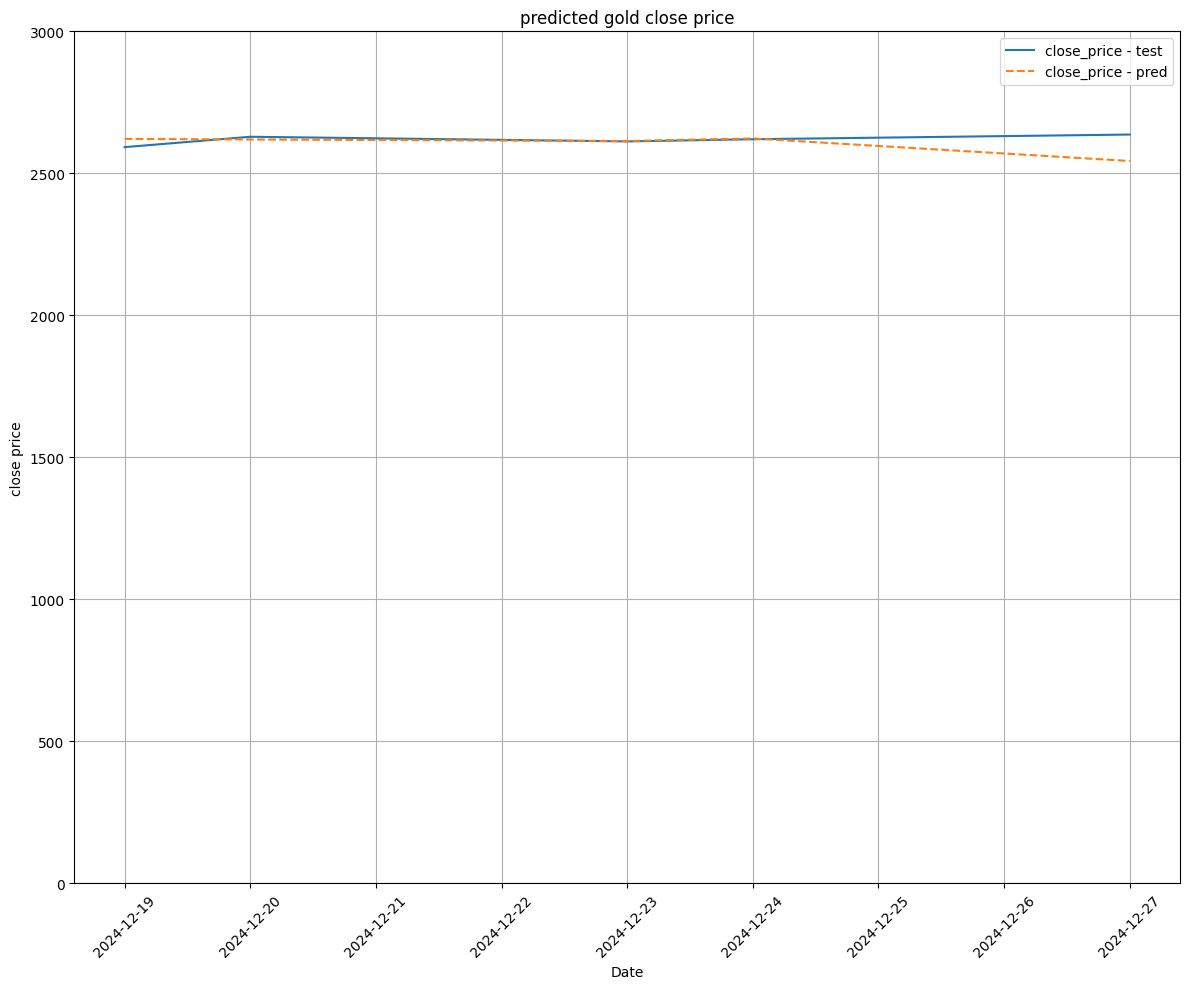

In [90]:
file_path = "../docs/goldPrice/assets/img/gold_price_hindcast_1day.png"
plt.figure(figsize=(12, 10))
plt.plot(hindcast_df["date"], hindcast_df["close_price"], label=f"close_price - test", color='black', linewidth=2, marker='^', markersize=5, markerfacecolor='grey')
plt.plot(hindcast_df["date"], hindcast_df["predicted_close_price"], label=f"close_price - pred", color='red', linewidth=2, marker='o', markersize=5, markerfacecolor='blue')
plt.title(f"predicted gold close price")
plt.xlabel("Date")
plt.ylabel("close price")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.ylim(0, 3000)
plt.tight_layout()
plt.savefig(file_path)
plt.show()
plt.show()